# 1. Build Packman Environment with OpenAI Gym

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import cv2

import tensorflow as tf
from tensorflow import keras

In [2]:
class PackmanEnv(Env):
    rewards = {
        'Start': 50,
        0: -1,
        1: -2,
        2: -2,
        3: -2,
        4: -2,
        'CollectDirt': 2,  # (-2 + 2 = 0)
        'EndGame': 100
    }
    actions = {
        0: "Stay",
        1: "Left",
        2: "Up",
        3: "Right",
        4: "Down"
    }
    def __init__(self):
        # Actions we can take, left, down, stay, up, right
        self.action_space = Discrete(5)
        
        # Define a 2-D observation space
        self.observation_shape = (10, 10, 3)
        self.observation_space = Box(low=np.zeros(self.observation_shape),
                                            high=np.ones(self.observation_shape),
                                            dtype=np.float32)
        # Set start state
        self.dict_state = self.init_state()
        self.canvas = self.convertToImage(self.dict_state)
        
        # Load human model from the computer
        self.human_model = tf.keras.models.load_model('./data/humanModel/mode_v0')
        
    def step(self, action):
        # Apply action
        # 0: "Stay"
        # 1: "Left"
        # 2: "Up"
        # 3: "Right"
        # 4: "Down"
        computer_reward = 0
        human_reward = 0
        
        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"
        
        human_pos = np.where(self.dict_state['Human trace'] == 1)
        computer_pos = np.where(self.dict_state['Computer trace'] == 1)
        # predict next human action
        
        # when human model is ready uncomment this line
#         human_action = self.predict_action(self.canvas)
        human_action = self.get_random_valid_action(human_pos)
    
        assert self.valid_action(action, computer_pos) , "Computer preformed invalid action: " + str(action) + " at pos: " + str(computer_pos)
        assert self.valid_action(human_action, human_pos) , "Human preformed invalid action: " + str(human_action) + " at pos: " + str(computer_pos)
    
        self.move(human_action, 'human') # assume human action is valid
        # apply the action to the agent
        self.move(action, 'computer')
        
        # check for clean dirt for both agents
        dirts_pos = np.where(self.dict_state['All awards'] == 1)
        for dirt_pos_i, dirt_pos_j in zip(dirts_pos[0], dirts_pos[1]):
            if human_pos[0][0] == dirt_pos_i and human_pos[1][0] == dirt_pos_j:
                self.dict_state['All awards'][human_pos] = 0
                self.dict_state['Human awards'][human_pos] = 1
                human_reward += self.rewards['CollectDirt']
            if computer_pos[0][0] == dirt_pos_i and computer_pos[1][0] == dirt_pos_j:
                self.dict_state['All awards'][computer_pos] = 0
                self.dict_state['Computer awards'][computer_pos] = 1
                computer_reward += self.rewards['CollectDirt']
                            
        # Reward for executing an action.
        computer_reward = self.rewards[action]
        human_reward = self.rewards[human_action]

        if not np.any(self.dict_state['All awards']): # game ended when there is no dirt to clean
            computer_reward += self.rewards['EndGame']
            human_reward += self.rewards['EndGame']
            done = True
        else:
            # Flag that marks the termination of an episode
            done = False
        
        self.ep_return += computer_reward
        self.ep_human_reward += human_reward
        
        self.canvas = self.convertToImage(self.dict_state)
        
        # Set placeholder for info
        info = {
                'done': done,
               'current_reward': computer_reward,
               'ep_return': self.ep_return,
               'human_return':self.ep_human_reward,
               }
        
        # Return step information
        return self.canvas, computer_reward, done, info

    def render(self, display=True):
        # Implement viz
        self.canvas = self.convertToImage(self.dict_state)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'Human reward: {} | Agent rewards: {}'.format(self.ep_human_reward, self.ep_return)
        
        # Put the info on canvas
        viz = cv2.putText(self.canvas, text, (10, 20), font,
                                  1, (255, 255, 255), 1, cv2.LINE_AA)
        
        return viz
    
    def reset(self):
        # Reset the reward
        self.ep_return = self.rewards['Start']
        self.ep_human_reward = self.rewards['Start']
        
        # Reset board game
        self.dict_state = self.init_state()
        self.canvas = self.convertToImage(self.dict_state)
        return self.canvas, self.ep_return
    
    def init_state(self):
        # init board state with random n=5 dirt position
        board = np.array([
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
                    [0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
                    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                    [0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
                    [0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
                    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                    [0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
                    [0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                ])
        human_trace = np.zeros(board.shape)
        human_trace[2][2] = 1 # locate human player
        board[2][2] = 0 # locate human player
        
        computer_trace = np.zeros(board.shape)
        computer_trace[7][7] = 1 # locate computer player
        board[7][7] = 0 # locate computer player
        
        human_awards = np.zeros(board.shape)
        computer_awards = np.zeros(board.shape)

        all_awards = np.zeros(board.shape)
        idx = np.random.choice(np.count_nonzero(board), 5)
        all_awards[tuple(map(lambda x: x[idx], np.where(board)))] = 1
        board[2][2] = 1 # locate human player
        board[7][7] = 1 # locate computer player
        
        return {
                'Board': board,
                'Human trace': human_trace,
                'Computer trace': computer_trace,
                'Human awards': human_awards,
                'Computer awards': computer_awards,
                'All awards': all_awards,
                }
    
    def get_random_valid_action(self, pos):
        random_action = self.action_space.sample()
        while not self.valid_action(random_action, pos):
            random_action = self.action_space.sample()
        return random_action
    
    def valid_action(self, action, pos):
        next_pos = self.new_pos(pos, action)
        if self.dict_state['Board'][next_pos] == 0:
            return False
        else:
            return True

    def new_pos(self, current_pos, action):
            if action == 0: # stay
                return current_pos
            elif action == 1: # left
                return (current_pos[0], current_pos[1]-1)
            elif action == 2: # up
                return (current_pos[0]-1, current_pos[1])
            elif action == 3: # right
                return (current_pos[0], current_pos[1]+1)
            elif action == 4: # down
                return (current_pos[0]+1, current_pos[1])
            else: # default case if action is not found
                assert True , "action: " + str(action) + " is not vallid at agent pos: " + str(current_pos) + " for agent: " + str(agent) 
                
    def move(self, action, agent):
        # assume action is valid
        if agent == 'human':
            current_pos = np.where(self.dict_state['Human trace'] == 1)
            self.dict_state['Human trace'] = self.dict_state['Human trace']*0.9
            next_pos = self.new_pos(current_pos, action)
            self.dict_state['Human trace'][next_pos] = 1
        elif agent == 'computer':
            current_pos = np.where(self.dict_state['Computer trace'] == 1)
            self.dict_state['Computer trace'] = self.dict_state['Computer trace']*0.9
            next_pos = self.new_pos(current_pos, action) 
            self.dict_state['Computer trace'][next_pos] = 1
        else:
            assert True , "agent not define:" + str(agent)
    
    def predict_action(self, img):
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = self.human_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        
        action = np.argmax(score)
#         print(
#             "This image most likely belongs to {} with a {:.2f} percent confidence."
#             .format(action, 100 * np.max(score))
#         )
        return action

    def convertToImage(self, state):
        r = state['Human awards']/2 + state['Human trace']
        g = state['Board']/3 + state['All awards']
        b = state['Computer awards']/2 + state['Computer trace']
        rgb = np.dstack((r,g,b))
        return (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)) # NormalizeImage
    

In [3]:
env = PackmanEnv()

C:\Users\USER\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


KeyboardInterrupt: 

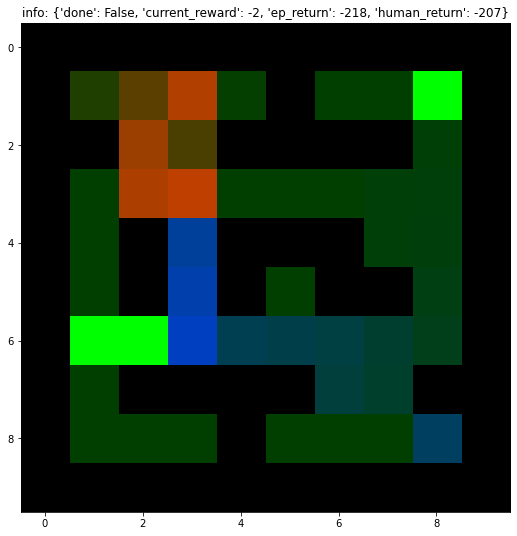

In [4]:
episodes = 10
for episode in range(1, episodes+1):
    state, score = env.reset()
    done = False
    
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render()) # only call this once
    
    while not done:

        computer_pos = np.where(env.dict_state['Computer trace'] == 1)
        action = env.get_random_valid_action(computer_pos)
        state, reward, done, info = env.step(action)
        
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.title(f'info: {info}')
        
        score += reward
#         print(info)
    print('Episode:{} Score:{}'.format(episode, score))

In [ ]:
# path
path = "./data/humanModel/imagesDatabase_split/val/37/-MhUR_hORqFZDHLqxzMH_2.png"
    
# Reading an image in default mode
image = cv2.imread(path)
  
# font
font = cv2.FONT_HERSHEY_SIMPLEX
  
# org
org = (50, 50)
  
# fontScale
fontScale = 1
   
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2
   
# Using cv2.putText() method
image = cv2.putText(image, 'OpenCV', org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
   
# Displaying the image
plt.imshow(image)

# 2. Create a Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
actions

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model 

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

# 3. Build Agent with Keras-RL

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=True)

# 4. Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)